In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')

In [3]:
X = df.drop(['overall_rating'], axis=1)
y = df['overall_rating']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

In [6]:
# from sklearn.model_selection import train_test_split

# # Split the data into 70% training, 15% validation and 15% test
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# print("Train set:", X_train.shape, y_train.shape)
# print("Validation set:", X_val.shape, y_val.shape)
# print("Test set:", X_test.shape, y_test.shape)


Train set: (12562, 57) (12562,)
Validation set: (2692, 57) (2692,)
Test set: (2693, 57) (2693,)


# Target Encoding

In [5]:
import pandas as pd
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

# Tách dữ liệu thành biến mục tiêu và các thuộc tính đầu vào
y = df['overall_rating']  # Biến mục tiêu
X = df.drop(columns=['overall_rating'])  # Các thuộc tính đầu vào
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

# Áp dụng Target Encoding cho cột 'nationality'
target_encoder = TargetEncoder()
X_train['nationality_encoded'] = target_encoder.fit_transform(X_train['nationality'], y_train)
X_test['nationality_encoded'] = target_encoder.transform(X_test['nationality'])

# Xóa cột 'nationality' gốc nếu không cần thiết
X_train.drop(columns=['nationality'], inplace=True)
X_test.drop(columns=['nationality'], inplace=True)

print("Dữ liệu huấn luyện sau khi mã hóa:")
X_train.head()


Dữ liệu huấn luyện sau khi mã hóa:


,age,height_cm,weight_kgs,potential,preferred_foot,weak_foot(1-5),skill_moves(1-5),crossing,finishing,heading_accuracy,...,positions_LB,positions_LM,positions_LW,positions_LWB,positions_RB,positions_RM,positions_RW,positions_RWB,positions_ST,nationality_encoded
15634,31,182.880000,77.1,73,1,4,3,64,73,58,...,0,0,1,0,0,0,0,0,1,68.070064
8147,20,182.102830,78.0,78,1,3,3,44,58,45,...,0,0,0,0,0,0,0,0,0,69.779778
13167,23,181.366882,73.0,77,1,3,3,64,47,56,...,0,0,0,0,1,0,0,0,0,65.710351
10766,27,190.500000,76.2,67,1,3,2,53,38,60,...,0,0,0,0,0,0,0,0,0,63.675918
15695,24,182.880000,76.2,78,0,4,3,68,62,57,...,0,0,0,0,0,0,0,0,0,71.076067


# Train Decision Tree với các tham số mặc định

In [27]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=0)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [28]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Training Set:')
print('MAE:', mean_absolute_error(y_train, y_train_pred))
print('MSE:', mean_squared_error(y_train, y_train_pred))
print('R2 score:', r2_score(y_train, y_train_pred))

print()

print('Test Set:')
print('MAE:', mean_absolute_error(y_test, y_test_pred))
print('MSE:', mean_squared_error(y_test, y_test_pred))
print('R2 score:', r2_score(y_test, y_test_pred))

Training Set:
MAE: 0.0
MSE: 0.0
R2 score: 1.0

Test Set:
MAE: 0.3234163463145579
MSE: 0.5630954370717032
R2 score: 0.9882368201808044


In [30]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [32]:
from sklearn.model_selection import cross_val_score

# Định nghĩa số lượng folds cho cross-validation
cv = 5

# Sử dụng cross_val_score để tính toán R^2 score
r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores cho {cv}-fold cross-validation: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

# Sử dụng cross_val_score để tính toán MSE (sử dụng scoring 'neg_mean_squared_error')
mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# Chuyển đổi MSE về giá trị dương
mse_scores = -mse_scores
print(f"MSE cho {cv}-fold cross-validation: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

# Đánh giá Mean Absolute Error (MAE)
mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE cho {cv}-fold cross-validation: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores cho 5-fold cross-validation: [0.98891431 0.99034733 0.9892928  0.98983439 0.98744534]
R^2 trung bình: 0.989 ± 0.001

MSE cho 5-fold cross-validation: [0.54345404 0.45710306 0.52047924 0.50459738 0.58735024]
MSE trung bình: 0.523± 0.043

MAE cho 5-fold cross-validation: [0.31058496 0.29387187 0.30983561 0.29785456 0.32488158]
MAE trung bình: 0.307 ± 0.011


# Đánh giá model với các max_depth khác nhau

In [10]:
def train_and_evaluate(max_depth=30):
    rg = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    rg.fit(X_train, y_train)
    y_train_pred = rg.predict(X_train)
    y_pred = rg.predict(X_test)

    train_MSE = mean_squared_error(y_train, y_train_pred)
    test_MSE = mean_squared_error(y_test, y_pred)

    train_MAE = mean_absolute_error(y_train, y_train_pred)
    test_MAE = mean_absolute_error(y_test, y_pred)

    train_R2 = r2_score(y_train, y_train_pred)
    test_R2 = r2_score(y_test, y_pred)

    return train_MSE, test_MSE, train_MAE, test_MAE, train_R2, test_R2, rg

In [11]:
max_depths = []
train_MSEs, test_MSEs = [], []
train_MAEs, test_MAEs = [], []
train_R2s, test_R2s = [], []
trees = []

for i in range(1, 31):
    train_MSE, test_MSE, train_MAE, test_MAE, train_R2, test_R2, rg = train_and_evaluate(i)
    max_depths.append(i)
    train_MSEs.append(train_MSE)
    test_MSEs.append(test_MSE)
    train_MAEs.append(train_MAE)
    test_MAEs.append(test_MAE)
    train_R2s.append(train_R2)
    test_R2s.append(test_R2)
    trees.append(rg)

In [12]:
print('Max depths:', max_depths)
print('Train MSE:', train_MSEs)
print('Test MSE:', test_MSEs)
print('Train MAE:', train_MAEs)
print('Test MAE:', test_MAEs)
print('Train R2:', train_R2s)
print('Test R2:', test_R2s)

Max depths: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Train MSE: [np.float64(21.86803490165416), np.float64(10.24466721726793), np.float64(6.09782090071549), np.float64(3.4575293542390244), np.float64(2.1346477612923502), np.float64(1.2456233397671137), np.float64(0.7814826882036856), np.float64(0.4823159111545537), np.float64(0.3183163767961438), np.float64(0.21141600092524535), np.float64(0.13213892319447001), np.float64(0.07581225874175238), np.float64(0.03917625309378659), np.float64(0.0193940305976275), np.float64(0.007530210233319561), np.float64(0.002890859489706255), np.float64(0.001135104660386388), np.float64(0.0005700434637245068), np.float64(0.00033433634236041456), np.float64(0.00024893521143139565), np.float64(0.00016716817118020728), np.float64(8.168444728123764e-05), np.float64(4.179204279505182e-05), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0),

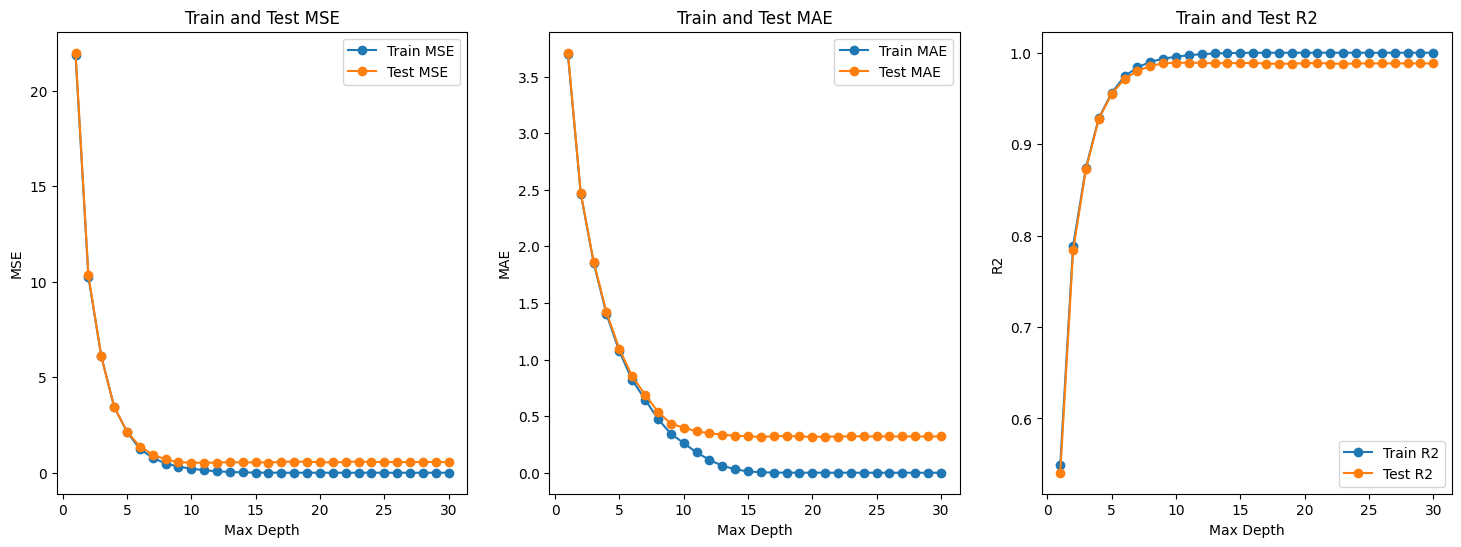

In [13]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(max_depths, train_MSEs, label='Train MSE', marker='o')
plt.plot(max_depths, test_MSEs, label='Test MSE', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.title('Train and Test MSE')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(max_depths, train_MAEs, label='Train MAE', marker='o')
plt.plot(max_depths, test_MAEs, label='Test MAE', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('MAE')
plt.title('Train and Test MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(max_depths, train_R2s, label='Train R2', marker='o')
plt.plot(max_depths, test_R2s, label='Test R2', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('R2')
plt.title('Train and Test R2')
plt.legend()

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Số lượng folds cho cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Các danh sách để lưu kết quả
max_depths = []
train_MSEs, test_MSEs = [], []
train_MAEs, test_MAEs = [], []
train_R2s, test_R2s = [], []

optimal_max_depth = 0

for depth in range(1, 31):
    train_MSE_fold, test_MSE_fold = [], []
    train_MAE_fold, test_MAE_fold = [], []
    train_R2_fold, test_R2_fold = [], []

    for train_index, test_index in kf.split(X):  # X là dữ liệu của bạn
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Huấn luyện mô hình với độ sâu max_depth
        model = DecisionTreeRegressor(max_depth=depth)
        model.fit(X_train, y_train)

        # Dự đoán trên tập train và test
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Tính các metric
        train_MSE_fold.append(mean_squared_error(y_train, y_train_pred))
        test_MSE_fold.append(mean_squared_error(y_test, y_test_pred))
        train_MAE_fold.append(mean_absolute_error(y_train, y_train_pred))
        test_MAE_fold.append(mean_absolute_error(y_test, y_test_pred))
        train_R2_fold.append(r2_score(y_train, y_train_pred))
        test_R2_fold.append(r2_score(y_test, y_test_pred))

    # Tính trung bình các metric qua các folds
    max_depths.append(depth)
    train_MSEs.append(np.mean(train_MSE_fold))
    test_MSEs.append(np.mean(test_MSE_fold))
    train_MAEs.append(np.mean(train_MAE_fold))
    test_MAEs.append(np.mean(test_MAE_fold))
    train_R2s.append(np.mean(train_R2_fold))
    test_R2s.append(np.mean(test_R2_fold))

    # Tìm max_depth tốt nhất dựa trên test_MSE
    if depth == 1 or test_MSEs[-1] < min(test_MSEs[:-1]):
        optimal_max_depth = depth



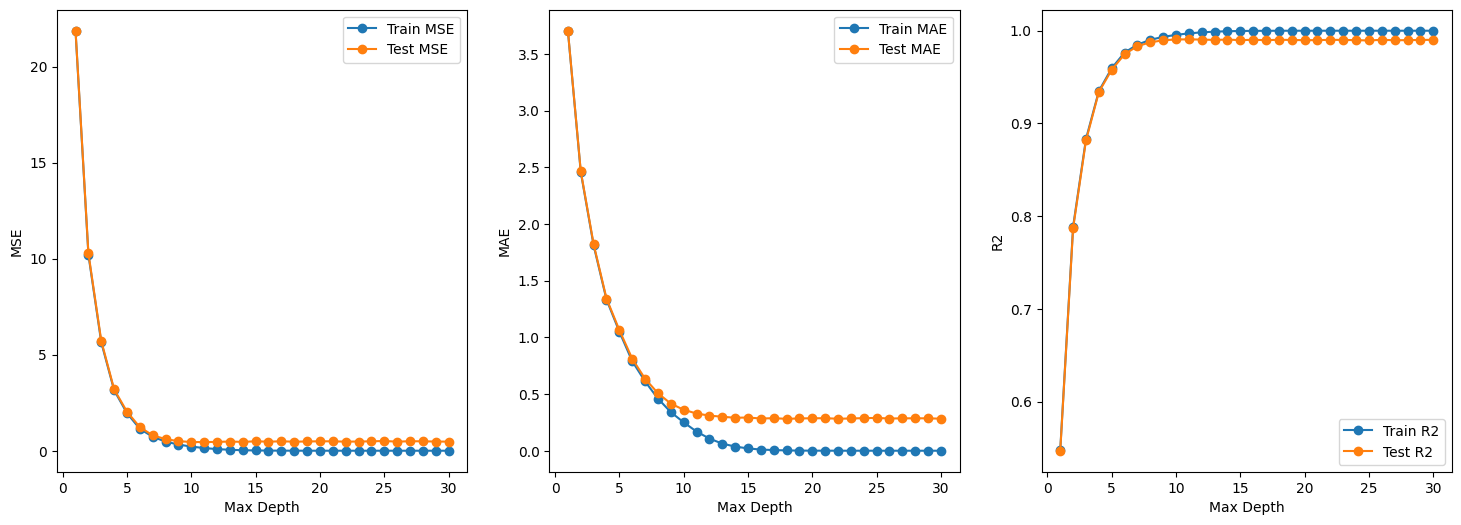

In [15]:
# Vẽ đồ thị như bạn đã thực hiện trước đó
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

# Đồ thị MSE
plt.subplot(1, 3, 1)
plt.plot(max_depths, train_MSEs, 'o-', label="Train MSE")
plt.plot(max_depths, test_MSEs, 'o-', label="Test MSE")
plt.xlabel("Max Depth")
plt.ylabel("MSE")
plt.legend()

# Đồ thị MAE
plt.subplot(1, 3, 2)
plt.plot(max_depths, train_MAEs, 'o-', label="Train MAE")
plt.plot(max_depths, test_MAEs, 'o-', label="Test MAE")
plt.xlabel("Max Depth")
plt.ylabel("MAE")
plt.legend()

# Đồ thị R2
plt.subplot(1, 3, 3)
plt.plot(max_depths, train_R2s, 'o-', label="Train R2")
plt.plot(max_depths, test_R2s, 'o-', label="Test R2")
plt.xlabel("Max Depth")
plt.ylabel("R2")
plt.legend()

plt.show()

In [16]:
optimal_max_depth

11

In [17]:
model = DecisionTreeRegressor(max_depth=optimal_max_depth)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=11)

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Training Set:')
print('MAE:', mean_absolute_error(y_train, y_train_pred))
print('MSE:', mean_squared_error(y_train, y_train_pred))
print('R2 score:', r2_score(y_train, y_train_pred))

print()

print('Test Set:')
print('MAE:', mean_absolute_error(y_test, y_test_pred))
print('MSE:', mean_squared_error(y_test, y_test_pred))
print('R2 score:', r2_score(y_test, y_test_pred))

Training Set:
MAE: 0.0
MSE: 0.0
R2 score: 1.0

Test Set:
MAE: 0.29041248606465997
MSE: 0.4855072463768116
R2 score: 0.9902733392760779


# Đánh giá tổng quát bằng cross validaiton score

In [26]:
from sklearn.model_selection import cross_val_score

# Định nghĩa số lượng folds cho cross-validation
cv = 10

# Sử dụng cross_val_score để tính toán R^2 score
r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores cho {cv}-fold cross-validation: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

# Sử dụng cross_val_score để tính toán MSE (sử dụng scoring 'neg_mean_squared_error')
mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# Chuyển đổi MSE về giá trị dương
mse_scores = -mse_scores
print(f"MSE cho {cv}-fold cross-validation: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

# Đánh giá Mean Absolute Error (MAE)
mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE cho {cv}-fold cross-validation: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores cho 10-fold cross-validation: [ 0.97411483  0.86356669  0.69046793  0.60288673  0.44306415 -0.41349896
 -0.36274688  0.35202692  0.5520346   0.90036437]
R^2 trung bình: 0.460 ± 0.464

MSE cho 10-fold cross-validation: [0.41654952 0.43805458 5.37152437 1.07599827 0.57054839 0.71517951
 0.60031625 0.43341752 0.44276724 1.14008872]
MSE trung bình: 1.120± 1.439

MAE cho 10-fold cross-validation: [0.26555813 0.32236202 1.48961582 0.71102987 0.3823075  0.48049866
 0.4474616  0.30399251 0.26605975 0.65185107]
MAE trung bình: 0.532 ± 0.351


# Plot learning curve

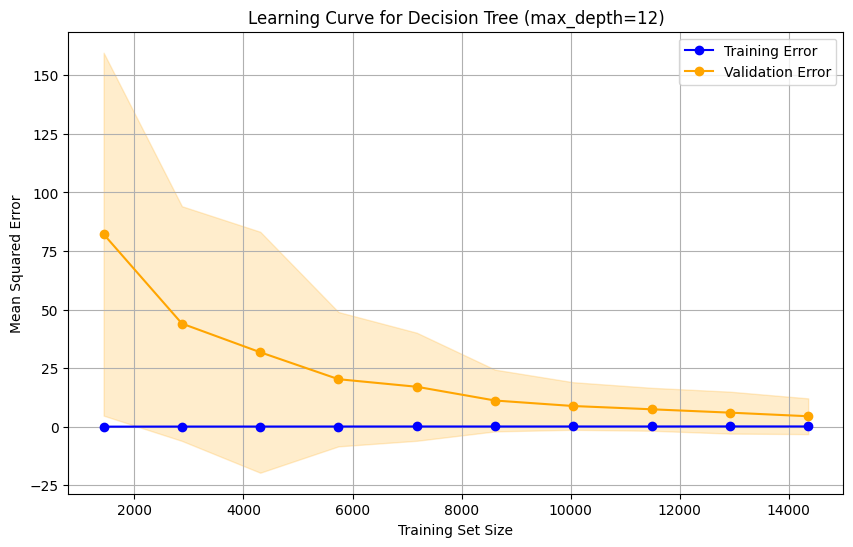

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeRegressor

# Khởi tạo mô hình với max_depth = 12
model = DecisionTreeRegressor(max_depth=12, random_state=42)

# Sử dụng hàm learning_curve để tính toán điểm số với các kích thước dữ liệu khác nhau
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='neg_mean_squared_error',  # Sử dụng MSE làm metric
    train_sizes=np.linspace(0.1, 1.0, 10),  # Các kích thước tập huấn luyện từ 10% đến 100%
    n_jobs=-1
)

# Tính trung bình và độ lệch chuẩn của các điểm số
train_scores_mean = -train_scores.mean(axis=1)  # Đổi sang giá trị dương để dễ đọc
train_scores_std = train_scores.std(axis=1)
test_scores_mean = -test_scores.mean(axis=1)  # Đổi sang giá trị dương để dễ đọc
test_scores_std = test_scores.std(axis=1)

# Vẽ learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error', color='blue', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validation Error', color='orange', marker='o')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color='orange')

plt.title("Learning Curve for Decision Tree (max_depth=12)")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.legend(loc="best")
plt.grid()
plt.show()


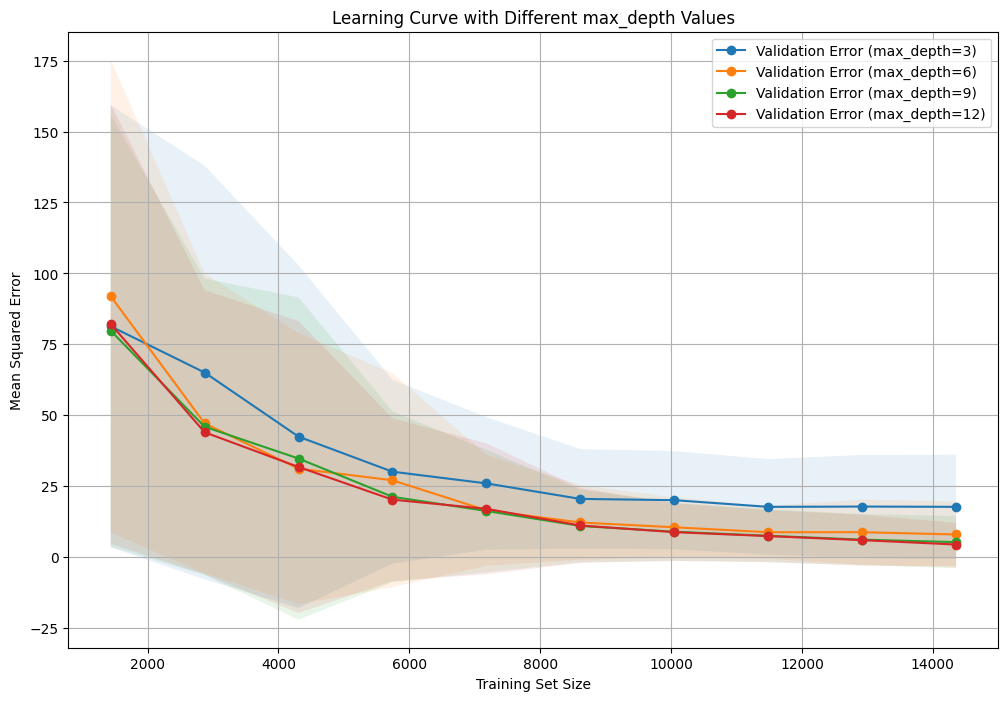

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeRegressor

train_sizes = np.linspace(0.1, 1.0, 10)

# Vẽ learning curve cho nhiều giá trị của max_depth
plt.figure(figsize=(12, 8))
for depth in [3, 6, 9, 12]:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error',
        train_sizes=train_sizes, n_jobs=-1
    )

    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.plot(train_sizes, test_scores_mean, label=f'Validation Error (max_depth={depth})', marker='o')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)

plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve with Different max_depth Values")
plt.legend(loc="best")
plt.grid()
plt.show()


# Chọn max_depth = 9

In [34]:
model = DecisionTreeRegressor(max_depth=9, random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=9, random_state=42)

In [35]:
from sklearn.model_selection import cross_val_score

# Định nghĩa số lượng folds cho cross-validation
cv = 10

# Sử dụng cross_val_score để tính toán R^2 score
r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores cho {cv}-fold cross-validation: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

# Sử dụng cross_val_score để tính toán MSE (sử dụng scoring 'neg_mean_squared_error')
mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# Chuyển đổi MSE về giá trị dương
mse_scores = -mse_scores
print(f"MSE cho {cv}-fold cross-validation: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

# Đánh giá Mean Absolute Error (MAE)
mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE cho {cv}-fold cross-validation: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores cho 10-fold cross-validation: [ 0.9652449   0.85633956  0.68354616  0.59656021  0.34861601 -0.5944025
 -0.49599438 -0.21822607  0.29447709  0.8997614 ]
R^2 trung bình: 0.334 ± 0.551

MSE cho 10-fold cross-validation: [0.55285042 0.48629234 5.5221595  1.35745043 0.63878723 0.81714028
 0.71373979 0.76265459 0.74569587 1.17969585]
MSE trung bình: 1.278± 1.438

MAE cho 10-fold cross-validation: [0.42658861 0.43425861 1.57654479 0.80661039 0.51875571 0.63358103
 0.58681332 0.60189904 0.44859502 0.70159399]
MAE trung bình: 0.674 ± 0.323
